In [1]:
import sys
sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt
import ahrs
import torch

from LeastSquaresQNN import LSQNN
from LeastSquaresCQNN import LSCQNN

import time
from sklearn.metrics import mean_squared_error

## Data Loading and Processing
Load the data from the files then create the training and testing sets.

Reference data shape: (87450, 10)
GNSS data shape: (2187, 7)
IMU data shape: (87450, 7)


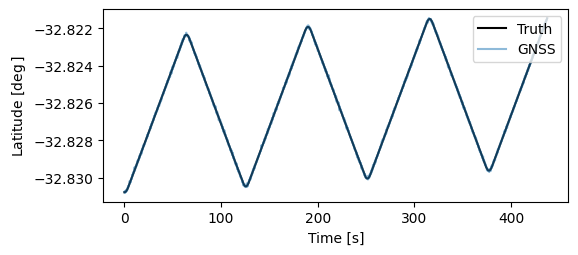

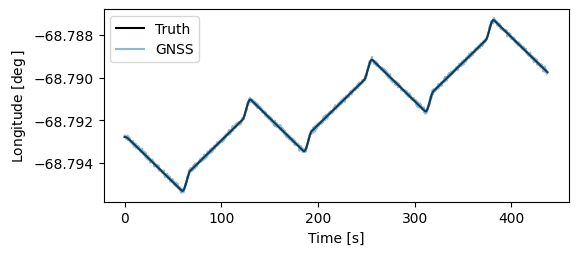

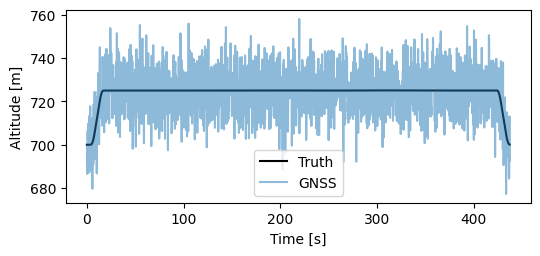

In [2]:
"""Load the data from the navego csv files, columns are different data points, rows are different samples"""
ref_data = np.genfromtxt("../Data/Navego/navego-synth-dataset/navego-synth-ref.csv", delimiter=",")
print(f"Reference data shape: {ref_data.shape}")
REF_TIME  = 0
REF_ROLL  = 1
REF_PITCH = 2
REF_YAW   = 3
REF_NVEL  = 4
REF_EVEL  = 5
REF_DVEL  = 6
REF_LAT   = 7
REF_LON   = 8
REF_ALT   = 9

gps_data = np.genfromtxt("../Data/Navego/navego-synth-dataset/navego-synth-gnss.csv", delimiter=",")
print(f"GNSS data shape: {gps_data.shape}")
GPS_TIME = 0
GPS_LAT  = 1
GPS_LON  = 2
GPS_ALT  = 3
GPS_NVEL = 4
GPS_EVEL = 5
GPS_DVEL = 6

imu_data = np.genfromtxt("../Data/Navego/navego-synth-dataset/navego-synth-imu2.csv", delimiter=",")
print(f"IMU data shape: {imu_data.shape}")
IMU_TIME = 0
IMU_XACC = 1
IMU_YACC = 2
IMU_ZACC = 3
IMU_XRAT = 4
IMU_YRAT = 5
IMU_ZRAT = 6

"""Plot GPS and truth data for latitude, longitude, and altitude"""
if True:
    plt.figure(figsize=(6,2.5))
    plt.plot(ref_data[:,REF_TIME], ref_data[:,REF_LAT]*ahrs.RAD2DEG, color="black", label="Truth")
    plt.plot(gps_data[:,GPS_TIME], gps_data[:,GPS_LAT]*ahrs.RAD2DEG, alpha=0.5, label="GNSS")
    plt.xlabel("Time [s]")
    plt.ylabel(r"Latitude [$\deg$]")
    plt.ticklabel_format(useOffset=False)
    plt.legend()

    plt.figure(figsize=(6,2.5))
    plt.plot(ref_data[:,REF_TIME], ref_data[:,REF_LON]*ahrs.RAD2DEG, color="black", label="Truth")
    plt.plot(gps_data[:,GPS_TIME], gps_data[:,GPS_LON]*ahrs.RAD2DEG, alpha=0.5, label="GNSS")
    plt.xlabel("Time [s]")
    plt.ylabel(r"Longitude [$\deg$]")
    plt.legend()

    plt.figure(figsize=(6,2.5))
    plt.plot(ref_data[:,REF_TIME], ref_data[:,REF_ALT], color="black", label="Truth")
    plt.plot(gps_data[:,GPS_TIME], gps_data[:,GPS_ALT], alpha=0.5, label="GNSS")
    plt.xlabel("Time [s]")
    plt.ylabel("Altitude [m]")
    plt.legend()

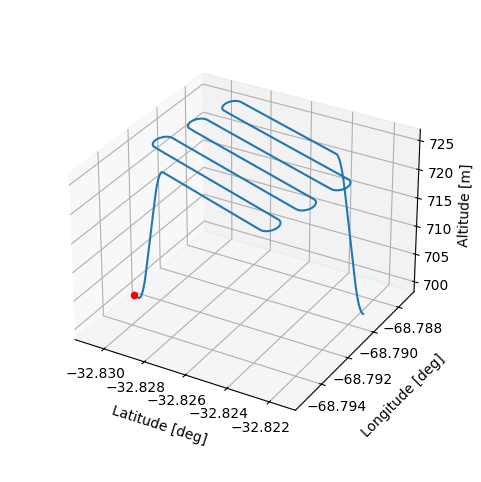

In [3]:
"""Plot the trajectory"""
plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')
ax.plot(ref_data[:,REF_LAT]*ahrs.RAD2DEG, ref_data[:,REF_LON]*ahrs.RAD2DEG, ref_data[:,REF_ALT])
ax.scatter(ref_data[0,REF_LAT]*ahrs.RAD2DEG, ref_data[0,REF_LON]*ahrs.RAD2DEG, ref_data[0,REF_ALT], color="red", label="Start")
ax.ticklabel_format(useOffset=False)
ax.set_xlabel("Latitude [deg]", labelpad=10)
ax.set_ylabel("Longitude [deg]", labelpad=15)
ax.set_zlabel("Altitude [m]")
ax.set_box_aspect(None, zoom=0.85)
ax.yaxis.set_ticks(np.arange(-68.794, -68.788, 0.002))
plt.show()

In [4]:
train_test_split = 0.5  # Train/test split (e.g. 0.4 means 40% train, 60% test)
normalize_input = True # Normalize mean and standard deviation of input
normalize_output = True # Normalize mean and standard deviation of output


"""Function for normalizing to mean=0 and std=1 along columns of data"""
def normalizeData(data, means, stds, inv=False):
    data_norm = np.empty_like(data)
    if inv == False:
        for col in range(data.shape[1]):
            data_norm[:,col] = (data[:,col] - means[col])/stds[col]
    else:
        for col in range(data.shape[1]):
            data_norm[:,col] = data[:,col]*stds[col] + means[col]
    return data_norm


"""
Datapoints and IMU/GPS sampling ratio calculations
1. Calculates the sampling rates for both the GPS and IMU
2. Calculates the number of IMU samples per GPS sample
3. Find the number of X and Y datapoints for CNN and MLP given delays
"""
# Get sampling periods for GPS and IMU, and find IMU samples per GPS sample
gps_sampling_rate = gps_data[1,GPS_TIME] - gps_data[0,GPS_TIME]
imu_sampling_rate = imu_data[1][IMU_TIME] - imu_data[0][IMU_TIME]
imu_per_gps = int(gps_sampling_rate/imu_sampling_rate)
att_data = ref_data[:,REF_ROLL:REF_YAW+1]
print(f"GPS Rate:{1/gps_sampling_rate}Hz, IMU Rate:{1/imu_sampling_rate}Hz, IMU samples per GPS sample:{imu_per_gps}")

# Get total number of datapoints for X and Y
if gps_data[-1][GPS_TIME] < imu_data[-1][IMU_TIME]:
    # Insufficient IMU data for first point
    datapoints = gps_data.shape[0] - 1 
else:
    # Insufficient IMU data for first and last GPS point
    datapoints = gps_data.shape[0] - 2


"""Generate X and Y for CNN"""
# ALL DATA (CNN, CQNN)
X_cnn = np.zeros((datapoints, 9, imu_per_gps))
Y_cnn = np.zeros((datapoints, 3))

for i in range(1, datapoints):
    k = int(i*imu_per_gps)
    # Generate new X sample
    gyro = np.expand_dims(imu_data[k-imu_per_gps:k,IMU_XRAT:IMU_ZRAT+1], axis=0)
    accel = np.expand_dims(imu_data[k-imu_per_gps:k,IMU_XACC:IMU_ZACC+1], axis=0)
    attitude = np.expand_dims(att_data[k-imu_per_gps:k,:], axis=0)
    # Combine data readings
    x_new = np.concatenate([gyro, accel, attitude], axis=2)
    x_new = np.transpose(x_new, axes=[0, 2, 1])

    # Generate new Y sample
    y_new = gps_data[i,GPS_LAT:GPS_ALT+1] - gps_data[i-1,GPS_LAT:GPS_ALT+1]

    # Add new samples to X and Y arrays
    X_cnn[i,:,:] = x_new
    Y_cnn[i,:] = y_new
print(f"X_cnn.shape:{X_cnn.shape}, Y_cnn.shape:{Y_cnn.shape}")

# Get norms and standard deviations of X and Y (CNN)
X_cnn_means = X_cnn.mean(axis=0)
X_cnn_std = X_cnn.std(axis=0)
Y_cnn_means = Y_cnn.mean(axis=0)
Y_cnn_std = Y_cnn.std(axis=0)
# Noramlize
if normalize_input == True:
    X_cnn = normalizeData(X_cnn, X_cnn_means, X_cnn_std)
if normalize_output == True:
    Y_cnn = normalizeData(Y_cnn, Y_cnn_means, Y_cnn_std)


"""Split data into train and test"""
train_index_cnn = int(datapoints*train_test_split)

X_cnn_train = X_cnn[:train_index_cnn,:]
Y_cnn_train = Y_cnn[:train_index_cnn,:]
X_cnn_test  = X_cnn[train_index_cnn:,:]
Y_cnn_test  = Y_cnn[train_index_cnn:,:]

GPS Rate:5.0Hz, IMU Rate:200.0Hz, IMU samples per GPS sample:40
X_cnn.shape:(2186, 9, 40), Y_cnn.shape:(2186, 3)


## Training
Training over training set and then evaluating over entire train and test set

In [5]:
learning_rate = 1e-2
weight_decay = 1e-2
momentum = 0.9
num_epochs = 2000
filter_size = 7

torch.manual_seed(0)

# CNN
_, input_channels, channel_size = X_cnn_train.shape
_, output_size = Y_cnn_train.shape
print(f"input_channels:{input_channels}, channel_size:{channel_size}, output_size={output_size}")

class CNN_GPS_Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv1d(in_channels=input_channels, out_channels=input_channels, kernel_size=filter_size, padding=0) 
        self.lin1 = torch.nn.Linear(in_features=input_channels*(channel_size-filter_size+1), out_features=output_size) 

    def forward(self, x):
        x = self.conv1(x) #in:40 -> out:31
        x = torch.nn.functional.relu(x)
        x = torch.flatten(input=x, start_dim=1) #in:9x31 -> out:279
        x = self.lin1(x) #in:45 -> out:16
        return x

CNN_model = CNN_GPS_Net()

X_train_tensor = torch.from_numpy(X_cnn_train)
X_train_tensor = X_train_tensor.to(torch.float32)
Y_train_tensor = torch.from_numpy(Y_cnn_train)
Y_train_tensor = Y_train_tensor.to(torch.float32)

loss = torch.nn.MSELoss()
optimizer = torch.optim.SGD(CNN_model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

tic = time.time()
CNN_model.train()
for epoch in range(1, num_epochs+1):
    Y_pred = CNN_model(X_train_tensor)
    loss_value = loss(Y_pred, Y_train_tensor)

    CNN_model.zero_grad()
    loss_value.backward()
    optimizer.step()
    if (epoch == 1) or (epoch % 50 == 0):
        print(f"Epoch {epoch} training loss: {loss_value.item():.4f}")
CNN_model.eval()
toc = time.time()
bpcnn_time = toc-tic

"""Run on all data"""
# Generate GPS predictions over entire dataset
X_tensor = torch.from_numpy(X_cnn)
X_tensor = X_tensor.to(torch.float32)
with torch.no_grad():
    Y_pred_cnn = CNN_model(X_tensor)
    Y_pred_cnn = Y_pred_cnn.numpy()

# De-normalize output
if normalize_output == True:
    Y_pred_cnn = normalizeData(Y_pred_cnn, Y_cnn_means, Y_cnn_std, inv=True)

# Sum deltas to form GPS estimate
gps_hat_cnn = np.zeros(shape=(Y_pred_cnn.shape[0], 3))
gps_hat_cnn[0,:] = [gps_data[0][GPS_LAT], gps_data[0][GPS_LON], gps_data[0][GPS_ALT]]
for i in range(Y_pred_cnn.shape[0]-1):
    gps_lat_new = gps_hat_cnn[i,0] + Y_pred_cnn[i,0]
    gps_lon_new = gps_hat_cnn[i,1] + Y_pred_cnn[i,1]
    gps_alt_new = gps_hat_cnn[i,2] + Y_pred_cnn[i,2]
    gps_hat_cnn[i+1,:] = [gps_lat_new, gps_lon_new, gps_alt_new]

"""Print Training Output"""
print(f"PyTorch CNN")
print(f"Training Samples, Channels, Data Per Channel: {X_cnn_train.shape}")
print(f"Training Time: {bpcnn_time:.3f}s")

input_channels:9, channel_size:40, output_size=3
Epoch 1 training loss: 1.1528
Epoch 50 training loss: 0.9718
Epoch 100 training loss: 0.9702
Epoch 150 training loss: 0.9698
Epoch 200 training loss: 0.9696
Epoch 250 training loss: 0.9694
Epoch 300 training loss: 0.9692
Epoch 350 training loss: 0.9691
Epoch 400 training loss: 0.9690
Epoch 450 training loss: 0.9689
Epoch 500 training loss: 0.9688
Epoch 550 training loss: 0.9687
Epoch 600 training loss: 0.9687
Epoch 650 training loss: 0.9686
Epoch 700 training loss: 0.9685
Epoch 750 training loss: 0.9685
Epoch 800 training loss: 0.9685
Epoch 850 training loss: 0.9684
Epoch 900 training loss: 0.9684
Epoch 950 training loss: 0.9683
Epoch 1000 training loss: 0.9683
Epoch 1050 training loss: 0.9683
Epoch 1100 training loss: 0.9682
Epoch 1150 training loss: 0.9682
Epoch 1200 training loss: 0.9682
Epoch 1250 training loss: 0.9681
Epoch 1300 training loss: 0.9681
Epoch 1350 training loss: 0.9681
Epoch 1400 training loss: 0.9681
Epoch 1450 traini

In [6]:
"""Least Square CQNN"""
filter_size = 7
beta = 100

X_cqnn_train = X_cnn_train.reshape((X_cnn_train.shape[0], -1))
X_cqnn_test = X_cnn_test.reshape((X_cnn_test.shape[0], -1))
X_cqnn = X_cnn.reshape((X_cnn.shape[0], -1))

lscqnn_singlechannel = LSCQNN()
tic = time.time()
lscqnn_singlechannel.Train(X_cqnn_train, Y_cnn_train, f=filter_size, beta=beta)
toc = time.time()
lscqnn_time = toc-tic

Y_pred_lscqnn = lscqnn_singlechannel.Eval(X_cqnn)

# De-normalize
if normalize_output == True:
    Y_pred_lscqnn = normalizeData(Y_pred_lscqnn, Y_cnn_means, Y_cnn_std, inv=True)

# Generate gps estimate
gps_hat_lscqnn = np.zeros(shape=(Y_pred_lscqnn.shape[0], 3))
gps_hat_lscqnn[0,:] = [gps_data[0][GPS_LAT], gps_data[0][GPS_LON], gps_data[0][GPS_ALT]]
for i in range(Y_pred_lscqnn.shape[0]-1):
    gps_lat_new = gps_hat_lscqnn[i,0] + Y_pred_lscqnn[i,0]
    gps_lon_new = gps_hat_lscqnn[i,1] + Y_pred_lscqnn[i,1]
    gps_alt_new = gps_hat_lscqnn[i,2] + Y_pred_lscqnn[i,2]
    gps_hat_lscqnn[i+1,:] = [gps_lat_new, gps_lon_new, gps_alt_new]

print(f"LS-CQNN Singlechannel")
print(f"Training Time: {lscqnn_time:.3f}s")

LS-CQNN Singlechannel
Training Time: 2.314s


In [8]:
"""Least Square CQNN Multichannel"""
filter_size = 7
beta = 100

lscqnn_multichannel = LSCQNN()
tic = time.time()
lscqnn_multichannel.Train(X_cnn_train, Y_cnn_train, f=filter_size, beta=beta, multi_channel=True)
toc = time.time()
lscqnn_multi_time = toc-tic

Y_pred_lscqnn_multi = lscqnn_multichannel.Eval(X_cnn)

# De-normalize
if normalize_output == True:
    Y_pred_lscqnn_multi = normalizeData(Y_pred_lscqnn_multi, Y_cnn_means, Y_cnn_std, inv=True)

# Generate gps estimate
gps_hat_lscqnn_multi = np.zeros(shape=(Y_pred_lscqnn_multi.shape[0], 3))
gps_hat_lscqnn_multi[0,:] = [gps_data[0][GPS_LAT], gps_data[0][GPS_LON], gps_data[0][GPS_ALT]]
for i in range(Y_pred_lscqnn_multi.shape[0]-1):
    gps_lat_new = gps_hat_lscqnn_multi[i,0] + Y_pred_lscqnn_multi[i,0]
    gps_lon_new = gps_hat_lscqnn_multi[i,1] + Y_pred_lscqnn_multi[i,1]
    gps_alt_new = gps_hat_lscqnn_multi[i,2] + Y_pred_lscqnn_multi[i,2]
    gps_hat_lscqnn_multi[i+1,:] = [gps_lat_new, gps_lon_new, gps_alt_new]

print(f"LS-CQNN Multichannel")
print(f"Training Time: {lscqnn_multi_time:.3f}s")

LS-CQNN Multichannel
Training Time: 2.170s


## Plot results

In [16]:
"""Plotting parameters"""
# What results to include
plot_lscqnn       = True
plot_lscqnn_multi = True
plot_bpcnn        = True

# Colors of each
color_truth        = "black"
color_lscqnn       = "royalblue"
color_lscqnn_multi = "forestgreen"
color_bpcnn        = "red"

lw = 1.5

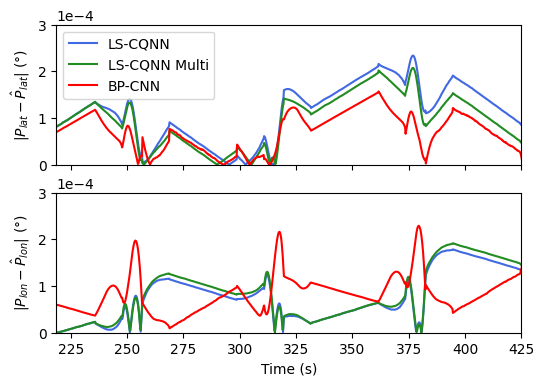

In [23]:
fig, axs = plt.subplots(2, figsize=(6,4))
axs[0].plot(gps_data[0:-1,GPS_TIME], abs(gps_hat_lscqnn[:,0] - ref_data[imu_per_gps::imu_per_gps,REF_LAT])*ahrs.RAD2DEG, label=f"LS-CQNN", linewidth=lw, color=color_lscqnn)
axs[0].plot(gps_data[0:-1,GPS_TIME], abs(gps_hat_lscqnn_multi[:,0] - ref_data[imu_per_gps::imu_per_gps,REF_LAT])*ahrs.RAD2DEG, label=f"LS-CQNN Multi", linewidth=lw, color=color_lscqnn_multi)
axs[0].plot(gps_data[0:-1,GPS_TIME], abs(gps_hat_cnn[:,0] - ref_data[imu_per_gps::imu_per_gps,REF_LAT])*ahrs.RAD2DEG, color=color_bpcnn, label="BP-CNN", linewidth=lw)

axs[0].ticklabel_format(axis="y", style='sci', scilimits=(0,0))
axs[0].tick_params(labelbottom=False)    
axs[0].set_ylabel(r"$|P_{lat} - \hat{P}_{lat}|$ ($\degree$)")
axs[0].set_xlim([gps_data[train_index_cnn,GPS_TIME], 425])
axs[0].set_ylim([0,0.0003])
axs[0].legend()

axs[1].plot(gps_data[0:-1,GPS_TIME], abs(gps_hat_lscqnn[:,1] - ref_data[imu_per_gps::imu_per_gps,REF_LON])*ahrs.RAD2DEG, label=f"LS-CQNN", linewidth=lw, color=color_lscqnn)
axs[1].plot(gps_data[0:-1,GPS_TIME], abs(gps_hat_lscqnn_multi[:,1] - ref_data[imu_per_gps::imu_per_gps,REF_LON])*ahrs.RAD2DEG, label=f"LS-CQNN Multi", linewidth=lw, color=color_lscqnn_multi)
axs[1].plot(gps_data[0:-1,GPS_TIME], abs(gps_hat_cnn[:,1] - ref_data[imu_per_gps::imu_per_gps,REF_LON])*ahrs.RAD2DEG, color=color_bpcnn, label="BP-CNN", linewidth=lw)

axs[1].ticklabel_format(axis="y", style='sci', scilimits=(0,0))
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel(r"$|P_{lon} - \hat{P}_{lon}|$ ($\degree$)")
axs[1].set_xlim([gps_data[train_index_cnn,GPS_TIME], 425])
axs[1].set_ylim([0,0.0003])
plt.show()

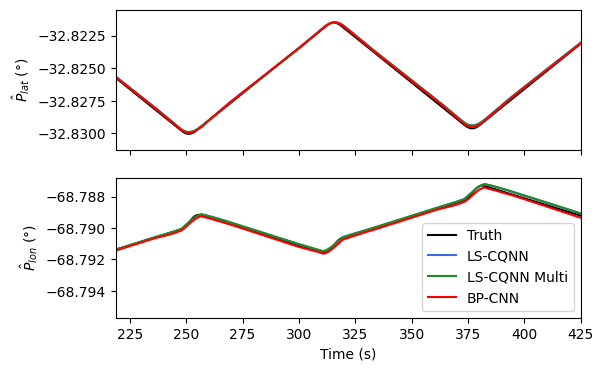

In [27]:
fig, axs = plt.subplots(2, figsize=(6,4))
axs[0].plot(gps_data[0:-1,GPS_TIME], ref_data[imu_per_gps::imu_per_gps,REF_LAT]*ahrs.RAD2DEG, label=f"Truth", linewidth=lw, color=color_truth)
axs[0].plot(gps_data[0:-1,GPS_TIME], gps_hat_lscqnn[:,0]*ahrs.RAD2DEG, label=f"LS-CQNN", linewidth=lw, color=color_lscqnn)
axs[0].plot(gps_data[0:-1,GPS_TIME], gps_hat_lscqnn_multi[:,0]*ahrs.RAD2DEG, label=f"LS-CQNN Multi", linewidth=lw, color=color_lscqnn_multi)
axs[0].plot(gps_data[0:-1,GPS_TIME], gps_hat_cnn[:,0]*ahrs.RAD2DEG, color=color_bpcnn, label="BP-CNN", linewidth=lw)

axs[0].ticklabel_format(axis="y", useOffset=False)
axs[0].tick_params(labelbottom=False)    
axs[0].set_ylabel(r"$\hat{P}_{lat}$ ($\degree$)")
axs[0].set_xlim([gps_data[train_index_cnn,GPS_TIME], 425])

axs[1].plot(gps_data[0:-1,GPS_TIME], ref_data[imu_per_gps::imu_per_gps,REF_LON]*ahrs.RAD2DEG, color=color_truth, label="Truth", linewidth=lw)
axs[1].plot(gps_data[0:-1,GPS_TIME], gps_hat_lscqnn[:,1]*ahrs.RAD2DEG, label=f"LS-CQNN", linewidth=lw, color=color_lscqnn)
axs[1].plot(gps_data[0:-1,GPS_TIME], gps_hat_lscqnn_multi[:,1]*ahrs.RAD2DEG, label=f"LS-CQNN Multi", linewidth=lw, color=color_lscqnn_multi)
axs[1].plot(gps_data[0:-1,GPS_TIME], gps_hat_cnn[:,1]*ahrs.RAD2DEG, color=color_bpcnn, label="BP-CNN", linewidth=lw)

axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel(r"$\hat{P}_{lon}$ ($\degree$)")
axs[1].set_xlim([gps_data[train_index_cnn,GPS_TIME], 425])
axs[1].legend()
plt.show()

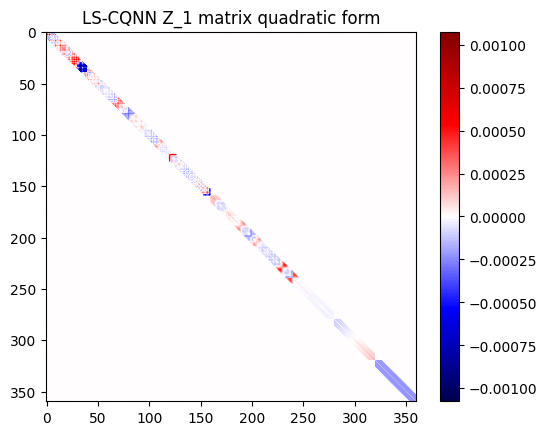

In [40]:
Z_lscqnn = lscqnn_singlechannel.Z_matrix(quadratic_params=True)
Z_lscqnn1 = Z_lscqnn[:-1,:-1]
plt.title("LS-CQNN Z_1 matrix quadratic form")
plt.imshow(Z_lscqnn1, cmap="seismic", vmin=-np.max(np.abs(Z_lscqnn1)), vmax=np.max(np.abs(Z_lscqnn1)))
# plt.axhline(Z_lscqnn1.shape[0]-1.5,color="black")
# plt.axvline(Z_lscqnn1.shape[0]-1.5,color="black")
plt.colorbar()
plt.show()